# WeatherBench - https://github.com/pangeo-data/WeatherBench

WeatherBench, created by [Rasp et al.](https://arxiv.org/abs/2002.00469), is a benchmark dataset based upon the ECMWF ERA5 reanalysis, framed as a weather forecasting challenge. 

This notebook is adapted from example notebooks in the WeatherBench repository. 

## Introduction

In its simplest setting you are provided with the current global values of Z500 (geopotential at 500hPa) & T850 (temperature at 850hPa) and the challenge is to predict the value of those fields 3 & 5 days ahead. Here we will focus just on Z500. For computational cost reasons we use data on a 5.625-degree grid, equivalent to 64x32 points. On a 0.25-degree grid the images would be 1440x720!

The task has attracted a lot of attention, with people applying many different architectures to the problem. This year alone we have seen Graph Neural Networks (https://arxiv.org/pdf/2202.07575) & Fourier-based approaches (https://arxiv.org/pdf/2202.11214).

With only a few hours & minimal computing hardware we cannot expect to best these efforts, but we can explore the problem and try a model.

## Direct or iterative? How best to deal with the time dimension?

Broadly, participants have tried two approaches to predict 3 & 5 days into the future.

1. The "direct" approach, provides the current state of the atmosphere as input and aims to jump directly to the lead time of interest, this often involves training two models, one for each lead time.

2. The "iterative" approach, seeks to learn to move forward on a shorter timescale, e.g. 6/12 hours, and then for inference you repeatedly apply the model to itself to get the desired leadtime. Recent models have tweaked this to include the iterative approach within the training loss.

## Uncertain predictions?

For medium range forecasting, learning not just the best guess but also uncertainty is important. [Clare et al.](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.4180) recently built a model to predict the PDF for each point in space. Here we will start by ignoring this element, but this could be an interesting thing to explore.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pip install climetlab-weatherbench --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
from weatherbench_score import *
from collections import OrderedDict
import climetlab as cml
from tqdm import tqdm

In [4]:
# Use CliMetLab to download and open the dataset
# For speed and simplicity we will only use Z500
# For the same reasons we will only use a few years of data.
ds = cml.load_dataset(
    'weatherbench',
    parameter = "geopotential_500hPa",
    year = list(range(2015,2019)),
).to_xarray()

#ds_t = cml.load_dataset('weather-bench',parameter = "temperature_850hPa").to_xarray()

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/mchantry/climetlab-weatherbench/blob/main/LICENSE. If you do not agree with such terms, do not download the data. 


  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
display(ds)

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 35064)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 500
  * time     (time) datetime64[ns] 2015-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-12 12:28:29 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

## Create data generator

First up, we want to write our own Keras data generator. The key advantage to just feeding in numpy arrays is that we don't have to load the data twice because our intputs and outputs are the same data just offset by the lead time. Since the dataset is quite large and we might run out of CPU RAM this is important.

In [6]:
# In this notebook let's only load a subset of the training data
ds_train = ds.sel(time=slice('2015', '2016'))
ds_valid = ds.sel(time=slice('2017', '2017'))

# For speed of testing just look at the first few months of 2018
ds_test = ds.sel(time=slice('2018', '2018')).isel(time=range(0,2000)) 

In [7]:
print("Training dataset")
display(ds_train)
print("----------------------------------------------------------------------")
print("Valdiation dataset")
display(ds_valid)
print("----------------------------------------------------------------------")
print("Testing dataset")
display(ds_test)

Training dataset


<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 17544)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 500
  * time     (time) datetime64[ns] 2015-01-01 ... 2016-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-12 12:28:29 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

----------------------------------------------------------------------
Valdiation dataset


<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 500
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-12 12:28:29 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

----------------------------------------------------------------------
Testing dataset


<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 2000)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 500
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-03-25T07:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(2000, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-12 12:28:29 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [8]:
#Again using the WeatherBench notebooks, we will build a data loader.
# This is an important part of any ML with large datasets.
# Keras uses this to build batches during training/validation
# On initialisation we calculate or store the normalisation values, to help the training progress efficiently
# the __getitem__ function is used by Keras to build batches of data.

class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            data.append(ds[var])
        data = xr.concat(data, 'level')
        self.data = data.transpose('time', 'lat', 'lon','level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        if load:
            print('Loading data into RAM')
            self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))
    
    # __getitem__ function is used by Keras to build batches of data.
    # if used during training it is important that the data generator has been 
    # intialised with shuffle=True.
    # You might observe slower training times if the data is not loaded into memory
    # but this might be necessary with large datasets on some machines.
    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time).values
        return X, y

    # this is called automatically by Keras at the end of the epoch
    # it reshuffles the dataset so the batches look different between epochs
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [9]:
# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None,}) #We're using z only for this model, but could include # 't': None})

## Let's try the iterative approach and learn to predict in 6hr steps.
You could try changing this to bigger increments, or go directly for 3/5 days.

In [10]:
# What size of batch do we want to use?
batch_size=32
# How many hours do we want to predict forward (multiple of 6)
lead_time = 6

assert lead_time % 6 == 0, "Lead time must be a multiple of 6"

Create a training, validation & test data generator. Use the train mean and std for validation as well.

Note that the validation & test datasets use the summary statistics calculated from the training dataset.

Also, we don't shuffle the validation and testing datasets.

In [11]:
dg_train = DataGenerator(
    ds_train, dic, lead_time, batch_size=batch_size, load=True
)
dg_valid = DataGenerator(
    ds_valid, dic, lead_time, batch_size=batch_size, load=False, mean=dg_train.mean, std=dg_train.std, shuffle=False
)
dg_test = DataGenerator(
    ds_test, dic, lead_time, batch_size=batch_size, load=False, mean=dg_train.mean, std=dg_train.std, shuffle=False
)

Loading data into RAM


In [12]:
display(dg_train.mean, dg_train.std)

<xarray.DataArray 'z' (level: 1)>
array([54178.98], dtype=float32)
Coordinates:
  * level    (level) int64 500

<xarray.DataArray 'z' (level: 1)>
array([1109.8843], dtype=float32)
Coordinates:
  * level    (level) int64 500

## Create and train model

Next up, we need to create the model architecture. Here we will use a convolutional network. Because the Earth is periodic in longitude, we want to use a periodic convolution in the longitude direction. This is not implemented in Keras, so we have to do it manually.

This might be your first time seeing custom layers. These have three components you need to provide.
1. An initialisation function, `__init__`, called when a layer is created, to save any layer parameters.
2. A `call` function, called when a layer is used, this could contain some mathematical operations.
3. A `get_config` function, useful for properly storing/loading the layer within a model.

Our Periodic Convolution comprises of 2 parts, one to do the periodic padding, and another to combine the padding with the convolution layer.

In [13]:
# This object pads a field (adding a margin to the field)
# in lon, this padding information comes from the periodicity, i.e. after 360 comes 0.
# in lat, we just pad with zeros, perhaps you have another idea of how to pad in this direction
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config

#Once we have created a periodic padding layer, the rest is easy
#A field comes in, we pad it, then pass to a normal 2D convolutional layer.
class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

In [14]:
# With the layer defined, our model looks really small!
# we use the functional API (see Wednesday's NN notebook)
def build_cnn(filters, kernels, input_shape, dr=0):
    """
    Fully convolutional network
    Filters & kernels, lists of same length (this length is the model depth)
    input_shape, the shape of our input tensor
    dr the dropout rate
    """
    #Create an input layer of the appropriate shape
    x = input = Input(shape=input_shape)
    #Loop over the depth
    for f, k in zip(filters[:-1], kernels[:-1]):
        #First a Periodic Conv2D
        x = PeriodicConv2D(f, k)(x)
        #Now a nonlinearity
        x = LeakyReLU()(x)
        #If we are worried about overfitting we can use Dropout
        #during training
        if dr > 0: x = Dropout(dr)(x)
    #One final linear layer to get the right number of outputs
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    #Construct the model from the graph
    return keras.models.Model(input, output)

### Build a model

We'll use 4 hidden layers with 32 filters in each.

In [15]:
cnn = build_cnn(
    filters = [32, 32, 32, 32, 1], 
    kernels = [5, 5, 5, 5, 5], 
    input_shape = (32, 64, 1)
)

2022-05-05 20:29:33.179007: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Use a very standard loss & optimiser
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 1)]       0         
                                                                 
 periodic_conv2d (PeriodicCo  (None, 32, 64, 32)       832       
 nv2D)                                                           
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 64, 32)        0         
                                                                 
 periodic_conv2d_1 (Periodic  (None, 32, 64, 32)       25632     
 Conv2D)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 64, 32)        0         
                                                                 
 periodic_conv2d_2 (Periodic  (None, 32, 64, 32)       25632 

In [17]:
# Since we didn't load the full data this is only for demonstration.
# without a GPU training is slow. You could try this on Colab or similar
cnn.fit(
    dg_train,
    epochs=3,
    validation_data=dg_valid, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=2,
            verbose=1, 
            mode='auto'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.25,
            patience=3,
        )
    ]
)

Epoch 1/3
549/549 [==============================] - 254s 461ms/step - loss: 0.2884 - val_loss: 0.0451
Epoch 2/3
549/549 [==============================] - 250s 455ms/step - loss: 0.0396 - val_loss: 0.0340
Epoch 3/3
549/549 [==============================] - 252s 459ms/step - loss: 0.0329 - val_loss: 0.0301


In [18]:
# We can save the weights to load later
# cnn.save_weights('test.h5')

In [19]:
# Here's one I trained earlier
# cnn_long_training.load_weights('cnn_6h.h5')

## Create predictions

Now that we have our model we need to create a prediction xarray object. This function does this. 

Depending on the model we trained we might have a model that directly predicts 3/5 days, or one that only predicts in 6hr steps.
With a direct approach, we would use the method below to construct our prediction.

With the iterative approach we would use `create_iterative_predictions` (see futher below) to iterate foreward to our desired lead times.

In [20]:
def create_predictions(model, dg):
    """Create predictions for non-iterative model"""
    preds = model.predict_generator(dg)
    # Unnormalize
    preds = preds * dg.std.values + dg.mean.values
    fcs = []
    lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None:
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx],
                dims=['time', 'lat', 'lon'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx:lev_idx+nlevs],
                dims=['time', 'lat', 'lon', 'level'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(fcs)

We won't use this here as we've made a model designed to predict only 6hr forward, so we will need to chain predictions together to reach 3 & 5 days.

In [21]:
#fc = create_predictions(cnn, dg_test)
#compute_weighted_rmse(fc, valid).compute()

In [22]:
#Here create a function for creating predictions for longer lead times by chaining increments together.
def create_iterative_predictions(model, dg, max_lead_time=5*24):
    state = dg.data[:dg.n_samples]
    preds = []
    #Do the prediction
    for _ in tqdm(range(max_lead_time // dg.lead_time)):
        state = model.predict(state)
        p = state * dg.std.values + dg.mean.values
        preds.append(p)
    preds = np.array(preds)
    
    #Create the xarray object
    lead_time = np.arange(dg.lead_time, max_lead_time + dg.lead_time, dg.lead_time)
    das = []; lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None:
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx],
                dims=['lead_time', 'time', 'lat', 'lon'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx:lev_idx+nlevs],
                dims=['lead_time', 'time', 'lat', 'lon', 'level'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(das)

### Let's evalute our model on the test set.
We'll roll the model out for 5 days and evaluate it.

In [23]:
%%time
fc_iter = create_iterative_predictions(cnn, dg_test)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


CPU times: user 3min 21s, sys: 5.3 s, total: 3min 27s
Wall time: 1min 1s


In [24]:
%%time
rmse = evaluate_iterative_forecast(fc_iter, ds_test, func = compute_weighted_rmse)
rmse.load()

CPU times: user 1.78 s, sys: 255 ms, total: 2.03 s
Wall time: 1.24 s


<xarray.Dataset>
Dimensions:    (lead_time: 20)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
    level      int32 500
Data variables:
    z          (lead_time) float64 189.3 277.2 387.5 ... 1.686e+03 1.876e+03

### Let's look at the error at 3 days

In [25]:
display(rmse.sel(lead_time=3*24))

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 72
    level      int32 500
Data variables:
    z          float64 988.4

### Plot the headline scores against a few benchmarks

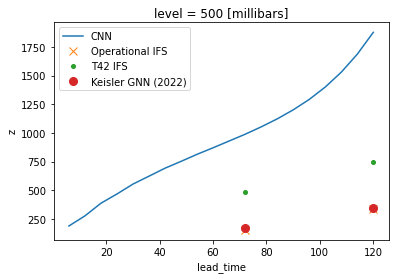

In [26]:
rmse.z.plot(label='CNN')
plt.plot([3*24, 5*24],[154,334],'x',label='Operational IFS', markersize=8)
plt.plot([3*24, 5*24],[489,743],'.',label='T42 IFS', markersize=8)
plt.plot([3*24, 5*24],[175,350],'o',label='Keisler GNN (2022)', markersize=8)
plt.legend()

### Our model lags a long way behind the Operational IFS.

However as you can see, [Keisler's GraphNN](https://arxiv.org/pdf/2202.07575) produced very comparable values. However there are some caveats with that work, as you integrate forward in time the images become blurred, scoring very well on RMSE but not capturing extreme values. More work will be required to establish if ML can produce sharp yet well scoring predictions.

Note that the test sets are not identical between our experiments and the others (due to time constraints), but we would expect to see only small differences with a different test set.

### Let's visualise our prediction

This plotting is taken from [here](https://github.com/pangeo-data/WeatherBench/blob/master/notebooks/4-evaluation.ipynb), where Rasp et al. show how to do a complete evaluation of a model.

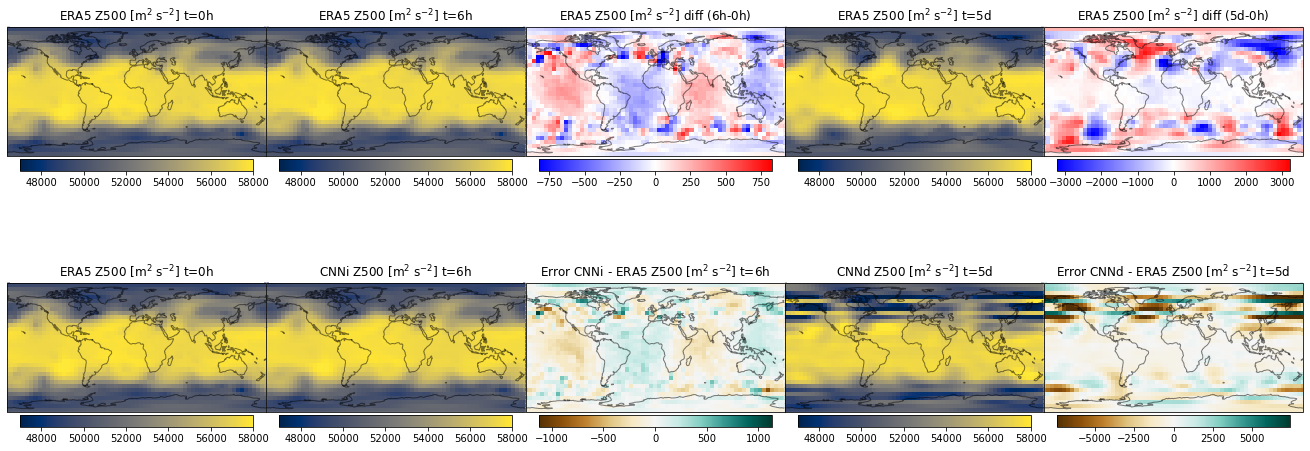

In [27]:
import cartopy.crs as ccrs
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

cmap_z = 'cividis'
cmap_t = 'RdYlBu_r'
cmap_diff = 'bwr'
cmap_error = 'BrBG'

def imcol(ax, data, title='', **kwargs):
    if not 'vmin' in kwargs.keys():
        mx = np.abs(data.max().values)
        kwargs['vmin'] = -mx; kwargs['vmax'] = mx
#     I = ax.imshow(data, origin='lower',  **kwargs)
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, 
                  rasterized=True, **kwargs)
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
    ax.set_title(title)
    ax.coastlines(alpha=0.5)
    return

fig, axs = plt.subplots(2, 5, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# True
for iax, var, cmap, r, t in zip(
    [0], ['z'], [cmap_z], [[47000, 58000]], [r'Z500 [m$^2$ s$^{-2}$]']):
    imcol(axs[iax,0], ds_test[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], ds_test[var].isel(time=6), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=6h')
    imcol(axs[iax,2],
        ds_test[var].isel(time=6)-ds_test[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (6h-0h)')
    imcol(axs[iax,3], ds_test[var].isel(time=5*24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=5d')
    imcol(axs[iax,4], 
        ds_test[var].isel(time=5*24)-ds_test[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (5d-0h)')

# CNN
for iax, var, cmap, r, t in zip(
    [1], ['z'], [cmap_z], [[47000, 58000]], [r'Z500 [m$^2$ s$^{-2}$]']):
    imcol(axs[iax,0], ds_test[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], fc_iter[var].isel(time=0).sel(lead_time=6), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNi {t} t=6h')
    imcol(axs[iax,2], 
        fc_iter[var].isel(time=0).sel(lead_time=6)-ds_test[var].isel(time=6), cmap=cmap_error,
        title=f'Error CNNi - ERA5 {t} t=6h')
    imcol(axs[iax,3], fc_iter[var].isel(time=0).sel(lead_time=5*24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNd {t} t=5d')
    imcol(axs[iax,4], 
        fc_iter[var].isel(time=0).sel(lead_time=5*24) - ds_test[var].isel(time=5*24), cmap=cmap_error,
        title=f'Error CNNd - ERA5 {t} t=5d')

for ax in axs.flat:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(pad=0)
#plt.savefig('../figures/examples.pdf', bbox_inches='tight')
# plt.savefig('../figures/examples.jpeg', bbox_inches='tight', dpi=300)

# What happens when we iterate for very long times?

Is the model stable, do the results look sensible?

PS Don't do this for the whole dataset as it will take a very long time.

# What could we do to improve this?

1. Rewrite the model with residual style blocks, i.e. seek to learn the increment to the current state.

2. Use a different type of network?

3. Change the hyper-parameters.

4. Use a local normalisation (i.e. the local mean & std).

5. Use more data?

6. Dilated convolutions (need to match with periodic padding)

7. Training the model with rollout
[See figure 2](https://arxiv.org/pdf/2202.11214.pdf)

8. Train a probabilistic model?

# Is WeatherBench a useful benchmark problem?

Can you think of applications for a fairly accurate model, perhaps one with slightly larger error than the IFS.

In [28]:
# One possible configuration of a residual network
def build_residual_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for i, (f, k) in enumerate(zip(filters[:-1], kernels[:-1])):
        x_in = x 
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)        
        if dr > 0: x = Dropout(dr)(x)
        if (i > 0) and (k == kernels[i-1]):
            x = Add()([x_in,x])
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)